Define TestRunner and TestPlan

In [1]:
import time
import json
import pandas as pd

from importlib import reload
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(filename)s:%(funcName)s - %(message)s',level=logging.INFO)

from elasticsearch import Elasticsearch
from clickhouse_driver import Client

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks", color_codes=True)

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

class TestRunner:
    def __init__(self, name, config):
        self.name = name
        self.config = config
    
    def run(self, case):
        pass

class ElasticsearchRuner(TestRunner):
    def __init__(self, name, config):
        TestRunner.__init__(self, name, config)
        self.client = Elasticsearch([self.config['cluster']])
        self.indices = self.config['indices']
           
    def run(self, case):
        query = case
        
        is_aggregation = False
        if 'aggs' in query:
            is_aggregation = True
        
        logging.debug(f'{self.name} run query {case}')
        start = time.time()
        response = self.client.search(index=self.indices, body=query, scroll='10m', size=10000)
        # enable scroll when it is not an aggregation search
        if not is_aggregation:
            sid = response['_scroll_id']
            scroll_size = len(response['hits']['hits'])
            while scroll_size > 0:
                data = self.client.scroll(scroll_id=sid, scroll='2m')
                # Update the scroll ID
                sid = data['_scroll_id']
                # Get the number of results that returned in the last scroll
                scroll_size = len(data['hits']['hits'])
        end = time.time()
        logging.debug(f'{self.name} run query complete')
        
        result = {}
        result['count'] = response['hits']['total']['value']
        result['response'] = response
        result['elapsed'] = end - start
        
        logging.debug(f'query result count {result["count"]} elapsed {result["elapsed"]}')
        return result
        
class ClickhouseRuner(TestRunner):
    def __init__(self, name, config):
        TestRunner.__init__(self, name, config)
        self.client = Client(self.config['cluster'])
    
    def run(self, case):
        query = case
        logging.debug(f'{self.name} run query {case}')
        start = time.time()
        response = self.client.execute(query)
        end = time.time()
        logging.debug(f'{self.name} run query complete')
        
        result = {}
        result['count'] = len(response)
        result['response'] = response
        result['elapsed'] = end - start
        
        logging.debug(f'query result count {result["count"]} elapsed {result["elapsed"]}')
        return result
    
class TestPlan:
    def __init__(self, planfile):
        with open(planfile) as json_file:
            self.plan = json.load(json_file)
            self.targets = []
            for target in self.plan['targets']:
                if target['type'] == 'elasticsearch':
                    runner = ElasticsearchRuner(target['name'], target['config'])
                    self.targets.append(runner)
                elif target['type'] == 'clickhouse':
                    runner = ClickhouseRuner(target['name'], target['config'])
                    self.targets.append(runner)
    
    def run(self):
        reports = []
        for testcase in self.plan['testcases']:
            name, description, cases = testcase
            report = {}
            report['name'] = name
            report['description'] = description
            report['result'] = []
            logging.info(f'run testcase {name} {description}')
            tests = list(zip(self.targets, cases))
            for test in tests:
                runner, query = test
                result = {}
                result['target'] = runner.name
                result['case'] = str(query)
                
                elapsed = []
                for i in range(self.plan['runs']):
                    run_result = runner.run(query)
                    elapsed.append(run_result['elapsed'])
                    
                result['elapsed'] = elapsed
                result['elapsed_total'] = sum(elapsed)
                report['result'].append(result)
                
            logging.info(f'run testcase {name} complete')
            reports.append(report)
        return self._summary(reports), self._detail(reports)
    
    def _summary(self, reports):
        #convert reports data to dataframe
        data = {}
        columns = []

        for report in reports:
            for result in report['result']:
                if 'name' not in data:
                    data['name'] = []
                    columns.append('name')
                data['name'].append(report['name'])
                
                if 'description' not in data:
                    data['description'] = []
                    columns.append('description')
                data['description'].append(report['description'])

                if 'target' not in data:
                    data['target'] = []
                    columns.append('target')
                data['target'].append(result['target'])

                if 'elapsed_total' not in data:
                    data['elapsed_total'] = []
                    columns.append('elapsed_total')
                data['elapsed_total'].append(result['elapsed_total'])

        summary_df = pd.DataFrame (data, columns = columns)
        return summary_df
    
    def _detail(self, reports):
        data = {}
        columns = []

        for report in reports:
            for result in report['result']:
                for elapsed in result['elapsed']:
                    if 'name' not in data:
                        data['name'] = []
                        columns.append('name')
                    data['name'].append(report['name'])

                    if 'description' not in data:
                        data['description'] = []
                        columns.append('description')
                    data['description'].append(report['description'])

                    if 'target' not in data:
                        data['target'] = []
                        columns.append('target')
                    data['target'].append(result['target'])

                    if 'elapsed' not in data:
                        data['elapsed'] = []
                        columns.append('elapsed')
                    data['elapsed'].append(elapsed)

        detail_df = pd.DataFrame (data, columns = columns)
        return detail_df
        

2021-07-21 08:52:16,068 - INFO - font_manager.py:_rebuild - Generating new fontManager, this may take some time...


Sample to run a test query

In [2]:
clickhouse_config = { "cluster" : "clickhouse"} 
clickhouse_runner = ClickhouseRuner('clickhouse', clickhouse_config)

query = 'SELECT * FROM syslog'
clickhouse_runner.run(query)

es_config = { "cluster" : "elasticsearch", "indices" : "syslog-*"} 
es_runner = ElasticsearchRuner('es', es_config)

query = {
    "query": {
        "match_all": {}
    }
}
es_runner.run(query)

2021-07-21 08:52:55,911 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/syslog-*/_search?scroll=10m&size=10000 [status:200 request:1.064s]
2021-07-21 08:52:56,330 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/_search/scroll?scroll=2m [status:200 request:0.345s]
2021-07-21 08:52:56,836 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/_search/scroll?scroll=2m [status:200 request:0.352s]
2021-07-21 08:52:57,277 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/_search/scroll?scroll=2m [status:200 request:0.339s]
2021-07-21 08:52:57,718 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/_search/scroll?scroll=2m [status:200 request:0.353s]
2021-07-21 08:52:58,109 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/_search/scroll?scroll=2m [status:200 request:0.301s]
2021-07-21 08:52:58,408 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/_search/sc

{'count': 67206,
 'response': {'_scroll_id': 'DXF1ZXJ5QW5kRmV0Y2gBAAAAAAAABrEWUE5sVHk1dTVUYXFuZ3NRakR1WXNjdw==',
  'took': 1018,
  'timed_out': False,
  '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
  'hits': {'total': {'value': 67206, 'relation': 'eq'},
   'max_score': 1.0,
   'hits': [{'_index': 'syslog-2021-07-21',
     '_type': '_doc',
     '_id': 'hog9yHoB4PD8gMOqtmjQ',
     '_score': 1.0,
     '_source': {'application': 'meln1ks',
      'hostname': 'for.us',
      'message': "There's a breach in the warp core, captain",
      'mid': 'ID642',
      'pid': '9602',
      'priority': 159,
      'raw': "<159>1 2021-07-21T08:45:24.581Z for.us meln1ks 9602 ID642 - There's a breach in the warp core, captain",
      'timestamp': '2021-07-21T08:45:24.581Z',
      'version': 1}},
    {'_index': 'syslog-2021-07-21',
     '_type': '_doc',
     '_id': 'h4g9yHoB4PD8gMOqtmjQ',
     '_score': 1.0,
     '_source': {'application': 'jesseddy',
      'hostname': 'we.com',
     

Run a test plan and show the test result

In [6]:
testplan = TestPlan("testplan.json")
summary_report, detail_report = testplan.run()

2021-07-21 09:17:16,126 - INFO - <ipython-input-1-626631c9da21>:run - run testcase case1 query all
2021-07-21 09:17:16,472 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/syslog-*/_search?scroll=10m&size=10000 [status:200 request:0.341s]
2021-07-21 09:17:16,915 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/_search/scroll?scroll=2m [status:200 request:0.365s]
2021-07-21 09:17:17,356 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/_search/scroll?scroll=2m [status:200 request:0.362s]
2021-07-21 09:17:17,889 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/_search/scroll?scroll=2m [status:200 request:0.342s]
2021-07-21 09:17:18,312 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/_search/scroll?scroll=2m [status:200 request:0.339s]
2021-07-21 09:17:18,733 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/_search/scroll?scroll=2m [status:200 request:0.338s]
2021-

2021-07-21 09:17:38,219 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/syslog-*/_search?scroll=10m&size=10000 [status:200 request:0.336s]
2021-07-21 09:17:38,626 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/_search/scroll?scroll=2m [status:200 request:0.339s]
2021-07-21 09:17:39,132 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/_search/scroll?scroll=2m [status:200 request:0.433s]
2021-07-21 09:17:39,548 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/_search/scroll?scroll=2m [status:200 request:0.328s]
2021-07-21 09:17:39,973 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/_search/scroll?scroll=2m [status:200 request:0.342s]
2021-07-21 09:17:40,405 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/_search/scroll?scroll=2m [status:200 request:0.347s]
2021-07-21 09:17:40,827 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/_search/sc

2021-07-21 09:18:05,019 - INFO - <ipython-input-1-626631c9da21>:run - run testcase case2 match all
2021-07-21 09:18:05,152 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/syslog-*/_search?scroll=10m&size=10000 [status:200 request:0.129s]
2021-07-21 09:18:05,176 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/_search/scroll?scroll=2m [status:200 request:0.003s]
2021-07-21 09:18:05,324 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/syslog-*/_search?scroll=10m&size=10000 [status:200 request:0.114s]
2021-07-21 09:18:05,353 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/_search/scroll?scroll=2m [status:200 request:0.004s]
2021-07-21 09:18:05,469 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/syslog-*/_search?scroll=10m&size=10000 [status:200 request:0.113s]
2021-07-21 09:18:05,499 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/_search/scroll?scroll=2m [stat

2021-07-21 09:18:16,220 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/_search/scroll?scroll=2m [status:200 request:0.038s]
2021-07-21 09:18:16,308 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/_search/scroll?scroll=2m [status:200 request:0.003s]
2021-07-21 09:18:16,612 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/syslog-*/_search?scroll=10m&size=10000 [status:200 request:0.297s]
2021-07-21 09:18:16,701 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/_search/scroll?scroll=2m [status:200 request:0.037s]
2021-07-21 09:18:16,711 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/_search/scroll?scroll=2m [status:200 request:0.002s]
2021-07-21 09:18:17,024 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/syslog-*/_search?scroll=10m&size=10000 [status:200 request:0.304s]
2021-07-21 09:18:17,113 - INFO - base.py:log_request_success - POST http://elasticsearch:9

2021-07-21 09:18:28,404 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/_search/scroll?scroll=2m [status:200 request:0.296s]
2021-07-21 09:18:28,735 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/_search/scroll?scroll=2m [status:200 request:0.278s]
2021-07-21 09:18:29,163 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/_search/scroll?scroll=2m [status:200 request:0.283s]
2021-07-21 09:18:29,482 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/_search/scroll?scroll=2m [status:200 request:0.255s]
2021-07-21 09:18:29,544 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/_search/scroll?scroll=2m [status:200 request:0.004s]
2021-07-21 09:18:29,839 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/syslog-*/_search?scroll=10m&size=10000 [status:200 request:0.282s]
2021-07-21 09:18:30,175 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/_search/sc

2021-07-21 09:18:47,170 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/_search/scroll?scroll=2m [status:200 request:0.290s]
2021-07-21 09:18:47,469 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/_search/scroll?scroll=2m [status:200 request:0.237s]
2021-07-21 09:18:47,544 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/_search/scroll?scroll=2m [status:200 request:0.002s]
2021-07-21 09:18:47,837 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/syslog-*/_search?scroll=10m&size=10000 [status:200 request:0.277s]
2021-07-21 09:18:48,173 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/_search/scroll?scroll=2m [status:200 request:0.275s]
2021-07-21 09:18:48,502 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/_search/scroll?scroll=2m [status:200 request:0.271s]
2021-07-21 09:18:48,836 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/_search/sc

2021-07-21 09:19:04,977 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/_search/scroll?scroll=2m [status:200 request:0.227s]
2021-07-21 09:19:05,037 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/_search/scroll?scroll=2m [status:200 request:0.003s]
2021-07-21 09:19:05,337 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/syslog-*/_search?scroll=10m&size=10000 [status:200 request:0.285s]
2021-07-21 09:19:05,676 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/_search/scroll?scroll=2m [status:200 request:0.281s]
2021-07-21 09:19:06,018 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/_search/scroll?scroll=2m [status:200 request:0.287s]
2021-07-21 09:19:06,349 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/_search/scroll?scroll=2m [status:200 request:0.272s]
2021-07-21 09:19:06,793 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/_search/sc

2021-07-21 09:19:23,536 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/_search/scroll?scroll=2m [status:200 request:0.132s]
2021-07-21 09:19:23,570 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/_search/scroll?scroll=2m [status:200 request:0.004s]
2021-07-21 09:19:23,874 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/syslog-*/_search?scroll=10m&size=10000 [status:200 request:0.294s]
2021-07-21 09:19:24,081 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/_search/scroll?scroll=2m [status:200 request:0.152s]
2021-07-21 09:19:24,108 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/_search/scroll?scroll=2m [status:200 request:0.003s]
2021-07-21 09:19:24,412 - INFO - base.py:log_request_success - POST http://elasticsearch:9200/syslog-*/_search?scroll=10m&size=10000 [status:200 request:0.293s]
2021-07-21 09:19:24,596 - INFO - base.py:log_request_success - POST http://elasticsearch:9

Detail report

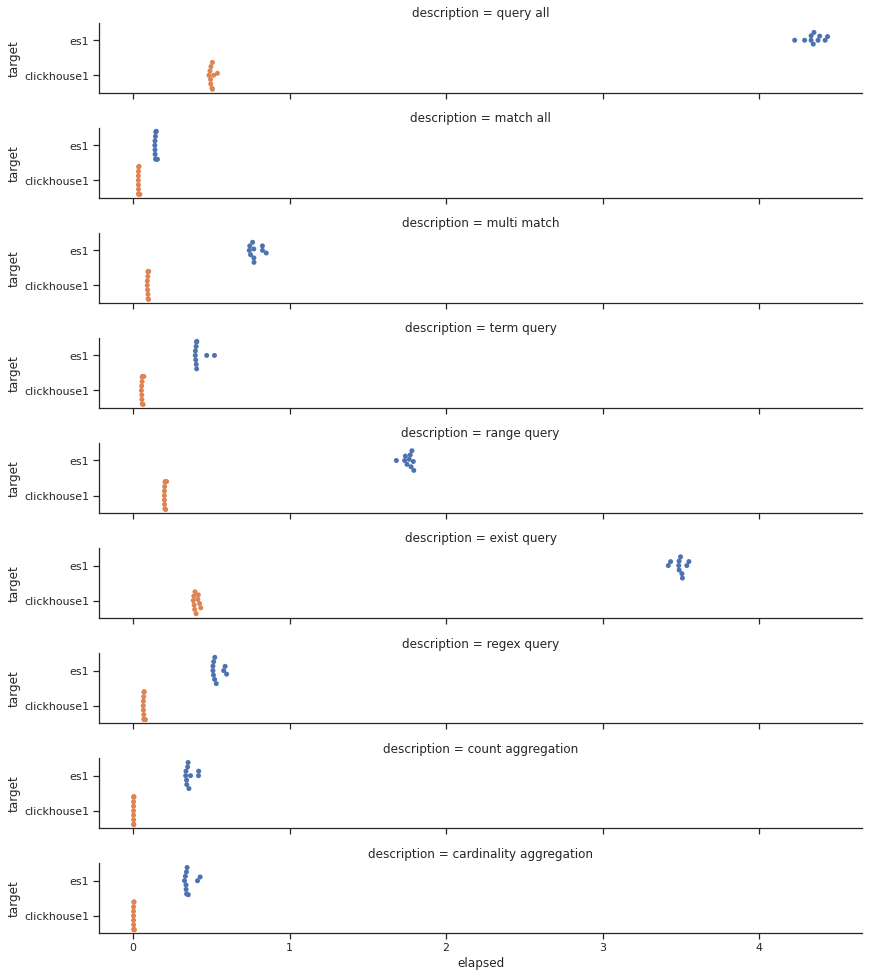

In [7]:
sns.catplot(x="elapsed", y="target", row="description", kind="swarm", 
            orient="h", height=1.5, aspect=8, 
            data=detail_report)

Summary report

<AxesSubplot:xlabel='elapsed_total', ylabel='description'>

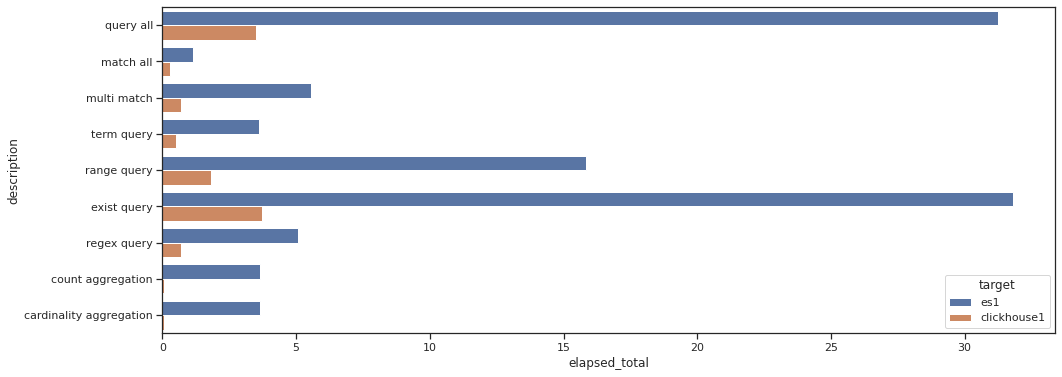

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 6))

sns.barplot(x="elapsed_total", y="description", hue="target",data=summary_report)